In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [49]:
DATA_DIR = "../data/ISIC_DATASET"  # root folder
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASSES = 3  # example: melanoma, nevus, benign
EPOCHS = 5
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

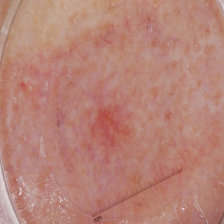

In [50]:
from PIL import Image

img = Image.open(f"{DATA_DIR}/train/benign/ISIC_0012155_downsampled.jpg")
img = img.resize((224, 224))
img

# Image Preprocessing & Augmentation


In [51]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load Dataset & DataLoader


In [52]:
train_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "train"), transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "val"), transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained MobileNetV2


In [53]:
model = models.mobilenet_v2(weights=True)

# Freeze Feature Extractor (Transfer Learning)


In [54]:
for param in model.features.parameters():
    param.requires_grad = False

# Replace Classifier


In [55]:
model.classifier = nn.Sequential(
    # regularization
    nn.Dropout(0.3),
    # Original MobileNet outputs 1000 classes, We replace it with our medical classes
    nn.Linear(model.last_channel, NUM_CLASSES),
)

In [56]:
model = model.to(DEVICE)

# Loss Function & Optimizer


In [57]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Training Loop


In [58]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(loader.dataset)
    return running_loss / len(loader), accuracy

# Run Training


In [59]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
# def validate(model, loader):
#     model.eval()
#     running_loss = 0
#     correct = 0

#     with torch.no_grad():
#         for images, labels in loader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             correct += (outputs.argmax(1) == labels).sum().item()

#     accuracy = correct / len(loader.dataset)
#     return running_loss / len(loader), accuracy

Save Model


In [ ]:
# torch.save(model.state_dict(), "mobilenet_isic.pth")